# Knowledge Graph generation 

In [1]:
import pandas as pd # Data manipulation and analysis
import numpy as np # Large, multi-dimensional arrays and matrices manipulations
import matplotlib.pyplot as plt # Statistical data visualization
import re # Provides regular expression matching operations similar to those found in Perl
import networkx as nx # Network ploting and manipulation
from gensim.models import KeyedVectors # Word embedding 
import spacy # NLP
from tqdm.notebook import tqdm # Loading bar for loops
import nltk # Natural Language Toolkit
import pickle
from transformers import CamembertModel, CamembertTokenizer, CamembertConfig
import torch

dir_path = "C:/"

## Load our text

In [2]:
import wikipedia
wikipedia.set_lang("fr")
p = wikipedia.page("Régression statistiques")
content = p.content # Content of page.

In [3]:
print(content[:2000])

En mathématiques, la régression recouvre plusieurs méthodes d’analyse statistique permettant d’approcher une variable à partir d’autres qui lui sont corrélées. Par extension, le terme est aussi utilisé pour certaines méthodes d’ajustement de courbe.
Le terme provient de la régression vers la moyenne observée par Francis Galton au XIXe siècle : les enfants de personnes de grande taille avaient eux-mêmes une taille supérieure à celle de la population en moyenne, mais inférieure à celle de leurs parents (toujours en moyenne), sans que la dispersion de taille au sein de la population totale ne soit réduite pour autant,. Les techniques développées pour quantifier ce phénomène ont engendré des outils de mesure précieux dans tous les champs d’application des statistiques.
En apprentissage automatique, on distingue les problèmes de régression des problèmes de classification. Ainsi, on considère que les problèmes de prédiction d'une variable quantitative sont des problèmes de régression tandis 

## Load our models :

In [4]:
# Load spacy's model :
nlp = spacy.load(dir_path + "Modeles et fichiers intermediaires/")

C:\Users\Joachim carvallo\anaconda3\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'fr_core_news_lg' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [5]:
# Load camembert :
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
camembert = CamembertModel.from_pretrained("camembert-base")

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# Load the entity classifier :
open_file = open(dir_path + "Modeles et fichiers intermediaires/result_dictionary_new", "rb")
result_dictionary = pickle.load(open_file)
open_file.close()

logisticRegr = result_dictionary[50][0][0]

# Load entities' names dictionnary
dic_entities_num_to_label = {
     1: 'contrôle', 2: 'processus', 3: 'établissements', 4: 'déplacements', 5: 'cible',
     6: 'réseaux', 7: 'matière', 8: 'machine', 9: 'identification', 10: 'installation',
     11: 'conducteur', 12: 'objectif', 13: 'commande', 14: 'achats', 15: 'interaction',
     16: 'fonction', 17: 'amont', 18: 'variations', 19: 'facturation', 20: 'environnement',
     21: 'véhicules', 22: 'vente', 23: 'enseignant/praticien', 24: 'utilisation', 25: 'magasin',
     26: 'disque/outils', 27: 'surface', 28: 'pièce', 29: 'diversité', 30: 'évaluation',
     31: 'particules', 32: 'logistique', 33: 'intégration', 34: 'intervention', 35: 'consommateurs/usagers',
     36: 'accès/droits', 37: 'paquet', 38: 'aspect', 39: 'événement', 40: 'réaction chimique',
     41: 'liquides', 42: 'information', 43: 'enjeu', 44: 'bâtiments', 45: 'variations',
     46: 'inspection', 47: 'incertitude', 48: 'entreprise', 49: 'démontage/mixage', 50: 'cohérence/fluidité',
     0: ''}
dic_entities_label_to_num = {v: k for k, v in dic_entities_num_to_label.items()}

In [7]:
# Load a pretrained word2vec embedding for french
word2vec = KeyedVectors.load_word2vec_format(dir_path + "Modeles et fichiers intermediaires/frWac_postag_no_phrase_700_skip_cut50.bin", 
                                          binary=True, unicode_errors="ignore")

# Manually defined clusters for our edges:
edge_clusters = {
    0:["être_v", "est_v"],
    1:["développer_v", "concevoir_v", "créer_v", "améliorer_v", "augmenter_v", "construire_v", "définir_v", "constituer_v", "déterminer_v", "introduire_v", "établir_v"],
    2:["avoir_v", "obtenir_v", "trouver_v", "disposer_v", "conserver_v", "stocker_v", "récupérer_v", "posséder_v"],
    3:["apporter_v", "fournir_v", "passer_v", "envoyer_v", "donner_v", "offrir_v", "rendre_v", "proposer_v", "répondre_v"],
    4:["faire_v", "mener_v", "travailler_v", "effectuer_v", "procéder_v", "poursuivre_v", "réaliser_v", "utiliser_v", "appliquer_v", "suivre_v", "adresser_v"],
    5:["illustrer_v", "présenter_v", "montrer_v", "représenter_v", "décrire_v"],
    6:["analyser_v", "étudier_v", "évaluer_v", "tester_v", "valider_v", "comparer_v", "observer_v", "confronter_v", "mesurer_v", "comprendre_v", "identifier_v", "détecter_v", "constater_v"],
    7:["nécessiter_v", "devoir_v", "souhaiter_v", "viser_v", "vouloir_v", "considérer_v", "envisager_v"],
    8:["calculer_v", "traiter_v", "connecter_v", "implémenter_v", "optimiser_v", "générer_v", "entraîner_v", "modéliser_v"]
}

cluster_names = {
    0:"être",
    1:"développer/permettre",
    2:"avoir",
    3:"proposer/offrir",
    4:"réaliser/permettre",
    5:"présenter/illustrer",
    6:"analyser/étudier",
    7:"nécessiter/devoir",
    8:"implémenter/calculer"
}

# Compute cluster centers/centroids :
clust_centers = []
for cluster in edge_clusters.values():
    center = []
    for word in cluster:
        center.append(word2vec[word])
    clust_centers.append(np.mean(center, axis = 0))

## Define our functions :

In [8]:
def texts_preprocessing(text):
    regex_1 = r'(\xa0)|(\t)|(\x1e)|•|-|…|«|»' # Suppress special spacings and bullets
    regex_2 = r'\nFigure.*[\.\n]' # Suppress figure legends
    regex_3 = r'(\n)(\d\.){1,}\d.*(\n)' # Suppress titles
    regex_4 = r'(\n) *\w{1,2} *[\.:]' # Suppress enumerations labels (i.e. " 1.", " 2:", " U :", ...)
    regex_5 = r'[^\.:;]*(\n)' # Suppress line breaks
    regex_6 = r'%' # Convert "%" to "pourcents"
    regex_7 = r' {2,}' # Suppress unnecessary spaces

    text = re.sub(regex_1, ' ', text)
    text = re.sub(regex_2, ' ', text)
    text = re.sub(regex_3, ' ', text)
    text = re.sub(regex_4, ' ', text)
    text = re.sub(regex_5, ' ', text)
    text = re.sub(regex_6, ' pourcents', text)
    text = re.sub(regex_7, ' ', text).strip()
    return text

In [9]:
def camembert_representation(text):
    
    # Tokenize our text:
    token_sentence_cam = tokenizer.tokenize(text)

    output_cam = []
    # Divide our text in blocks of 510 tokens to pass it trough Camembert:
    for i in range(((len(token_sentence_cam)-1) // 510) + 1):
        encoded_sentence = tokenizer.encode(token_sentence_cam[i*510:np.min([(i+1)*510, len(token_sentence_cam)])])
        encoded_sentence = torch.tensor(encoded_sentence).unsqueeze(0)
        out = camembert(encoded_sentence)
        # Keep the layer --> dim: 510 x 768
        output_cam.append(out["last_hidden_state"][0,1:-1,:])
    
    # Stack together our blocks of dim 510 x 768:
    output_cam = torch.cat(output_cam, axis = 0)
    return token_sentence_cam, output_cam

In [10]:
# old_dic_entities_label_to_num serve to map all entities found by Spacy's base NER module to 1. 
old_dic_entities_label_to_num = {'':0, 'LOC':1, 'MISC':1, 'ORG':1, 'PER':1}

def tokens_extraction(doc):
    
    ents_list = list(doc.ents)
    ents_count = 0
    next_ent = ents_list[ents_count]

    tokens_text = []
    tokens_tags = []
    tokens_ids = []
    entities_labels = []
    i = 0
    
    # Go through every token of our text: 
    while i < len(doc): 
        # If we are still before the next entity: add the word, its tag, ids and label to our lists.
        if i < next_ent.start:
            tokens_text.append(doc[i].text)
            tokens_tags.append(doc[i].tag_)
            tokens_ids.append([i, i+1])
            entities_labels.append(old_dic_entities_label_to_num[doc[i].ent_type_])
            i += 1
        # If we are in a entity...
        else :
            # If the entity is divided by a coma, split it.
            if ", " in next_ent.text:
                idx = 0
                for sub_ent in next_ent.text.split(", "):
                    if sub_ent != "":
                        sub_doc = nlp(sub_ent)
                        tokens_text.append(sub_ent)
                        tokens_tags.append("ENTITY")
                        tokens_ids.append([i+idx,i+idx+len(sub_doc)])
                        entities_labels.append(old_dic_entities_label_to_num[sub_doc[0].ent_type_])
                        idx += len(sub_doc) + 1
                    if sub_ent != next_ent.text.split(", ")[-1]:
                        tokens_text.append(",")
                        tokens_tags.append("PUNCT") 
                        tokens_ids.append([i+idx-1,i+idx])
                        entities_labels.append(0)
            # Otherwise: add the entity, its tag, ids and label to our lists.
            else :
                tokens_text.append(next_ent.text)
                tokens_tags.append("ENTITY") 
                tokens_ids.append([i, next_ent.end])
                entities_labels.append(old_dic_entities_label_to_num[doc[next_ent.start].ent_type_])
            
            # Then, go straight to the end of the entity.
            i = next_ent.end 
            
            # Update the next entity.
            if ents_count < len(ents_list)-1:
                ents_count += 1
                next_ent = ents_list[ents_count]
            else : 
                next_ent.start = len(doc)

    return tokens_text, tokens_tags, tokens_ids, entities_labels

In [11]:
def entity_labelling(tokens_text, tokens_tags, tokens_ids, token_sentence_cam, output_cam):

    entities_labels = []
    i = 0
    full_text = ''
    
    # Go through every token of our text: 
    for text, tag, ids in zip(tokens_text, tokens_tags, tokens_ids):
        
        # Look for entities (otherwise we add 0 to our list of labels)
        if tag == "ENTITY":
            entity = doc[ids[0]:ids[1]]
            idx_first_noun_of_entity = entity[0].idx
            word = entity.text
            # Find the first NOUN in the entity (if there is one, otherwise use the first token)
            for tok in entity:
                if tok.tag_ == "NOUN":
                    idx_first_noun_of_entity = tok.idx
                    word = tok.text
                    break        
                
            # Full text is the concatenation of the tokens generated by Camembert (that are different that spacy's tokens).
            # The aim is to find the Camembert representations of certain spacy's tokens.

            cam_tok, cam_vect = re.sub(r'▁', '', token_sentence_cam[i]), output_cam[i]

            # If the next entity is the next Camembert's token: predict its label with our model. 
            if len(full_text) == idx_first_noun_of_entity:
                pred_rf = logisticRegr.predict(cam_vect.reshape(1,-1).detach().numpy())
                entities_labels.append(pred_rf.item()+1)

            # Otherwise, go throught the next Camembert tokens one by one, until we get to the next entity.
            else :
                while (i < len(token_sentence_cam)-2): # & (len(full_text) <= idx_first_noun_of_entity):
                    cam_tok = re.sub(r'▁', '', token_sentence_cam[i])
                    next_cam_tok, next_cam_vect = token_sentence_cam[i+1], output_cam[i+1]

                    if '▁' in next_cam_tok:
                        full_text += cam_tok + " "
                    else:
                        full_text += cam_tok

                    if len(full_text) >= idx_first_noun_of_entity:

                        # If our Camembert tokens align properly with Spacy's tokens.
                        if (full_text[idx_first_noun_of_entity:np.min([idx_first_noun_of_entity+len(word),len(full_text)])] == word[:(len(full_text) - idx_first_noun_of_entity)]):
                            mean_cam_vect = next_cam_vect
                            j = i+2

                            # Camembert often split words in multiple parts, this while loop serve to obtain the mean of the representations of the parts.
                            while (j < len(token_sentence_cam)-1) & ('▁' not in token_sentence_cam[j]) & (token_sentence_cam[j] not in ".?!,;:-/()"):
                                mean_cam_vect += output_cam[j]
                                j += 1
                            mean_cam_vect /= j-(i+1)
                            pred_rf = logisticRegr.predict(mean_cam_vect.reshape(1,-1).detach().numpy())
                            entities_labels.append(pred_rf.item()+1)
                            i += 1
                            break
                        # Otherwise, forget the entity and proced for the next one.
                        else:
                            entities_labels.append(0)
                            full_text = full_text[:idx_first_noun_of_entity]
                            i += 1
                            break
                    i += 1
        else:
            entities_labels.append(0)

    # If we have less labels than tokens, we might have an alignment problem for the last entities. We juste complete with labels 0.
    while len(entities_labels) < len(tokens_text):
        entities_labels.append(0)
            
    return entities_labels

In [12]:
def tokens_preprocessing(tokens_text, tokens_tags, tokens_ids, entities_labels):
    
    punctuation = ".?!,;:-/"
    i = 0
    
    # For every token...
    while i < len(tokens_text):
        # Remove punctation from the end of ENTITYs
        if (tokens_tags[i] == "ENTITY") & (tokens_text[i][-1] in punctuation):
            tokens_text = tokens_text[:i] + [tokens_text[i][:-1]] + [tokens_text[i][-1]] + tokens_text[(i+1):]
            tokens_tags = tokens_tags[:(i+1)] + ["PUNCT"] + tokens_tags[(i+1):]
            tokens_ids = tokens_ids[:i] + [[tokens_ids[i][0], tokens_ids[i][1]-1]] + [[tokens_ids[i][1]-1, tokens_ids[i][1]]] + tokens_ids[(i+1):]
            entities_labels = entities_labels[:(i+1)] + [0] + entities_labels[(i+1):]
        i += 1
        
    return tokens_text, tokens_tags, tokens_ids, entities_labels

In [13]:
def find_vrb_obj_and_extract_relation(i, sbj, sbj_clust, relations, relations_clusterised, doc, texts, tags, ids, labels):
    obj = ""
    vrb = ""
    new_k = 0
    is_neg = False
    # Go through every words after the first VERB until we find the object or a new entity
    for k in range(i, len(texts)):
        if (labels[k] != 0) & ("xcomp" not in [child.dep_ for child in doc[ids[i][0]].children]):
            break

        vrb += texts[k] + " "
        vrb_lemma = doc[ids[k][0]].lemma_
        
        if tags[k] == "VERB":
            # Find if there is a negation in the sentence
            for child in doc[ids[k][0]].children:
                if (child.dep_ == "advmod") & (child.text in ["n’", "pas", "n'"]):
                    is_neg = True
            # Go through every descendant of the VERB to find every objects and then extract relations
            for child in doc[ids[k][0]].children:
                if child.dep_[:min([len(child.dep_),3])] in ["obj", "obl"]:                    
                    # Go through every tokens after the VERB to find where is the OBJECT and if it's an entity
                    for j in range(len(texts)):
                        if ((child.i < ids[j][1]) & (child.i >= ids[j][0])) & (labels[j] != 0):
                            obj = texts[j]
                            obj_clust = dic_entities_num_to_label[labels[j]]
                            if is_neg:
                                relations_clusterised.append([sbj_clust, "(pas) " + vrb_lemma, obj_clust])
                                if "pas" not in vrb:
                                    relations.append([sbj, "(pas) " + vrb, obj])
                                else:
                                    relations.append([sbj, vrb, obj])
                            else:
                                relations.append([sbj, vrb, obj])
                                relations_clusterised.append([sbj_clust, vrb_lemma, obj_clust])
                            new_k = k
                            break
            if obj != "":
                break
    
    return relations, relations_clusterised, new_k

def relation_extraction(doc, tokens_text, tokens_tags, tokens_ids, entities_labels):

    # Split our lists by sentences :
    size = len(tokens_text)
    idx_list = [idx + 1 for idx, token in enumerate(tokens_text) if token == "."]
    tokens_text_sentences = [tokens_text[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))]
    tokens_tags_sentences = [tokens_tags[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))]
    tokens_ids_sentences = [tokens_ids[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))]
    entities_labels_sentences = [entities_labels[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))]

    all_relations = []
    all_relations_clusterised = []
    
    # Go through every sentences one by one 
    for texts, tags, ids, labels in zip(tokens_text_sentences, tokens_tags_sentences, tokens_ids_sentences, entities_labels_sentences):
        
        relations = []
        relations_clusterised = []
        
        ### I. Find a verb in the sentence with its SUBJECT :
        for i in range(len(texts)):
            if tags[i] == "VERB":
                sbj = ""
                # Go through every antecedent of the VERB to find the SUBJECT
                for child in doc[ids[i][0]].children:
                    if child.dep_[:min([len(child.dep_),5])] == "nsubj":
                        # Go through every tokens before the VERB to find where is the SUBJECT and if it's an entity
                        for j in range(len(texts)):
                            if ((child.i < ids[j][1]) & (child.i >= ids[j][0])) & (labels[j] != 0):
                                sbj = texts[j]
                                sbj_clust = dic_entities_num_to_label[labels[j]]
                                break # Stop iterating, we have our token
                        break # Stop iterating, there is only one SUBJECT
                        
                ### II. Find the complete VERB group and the OBJECT
                if sbj != "":
                    
                    # II.1. The normal situation ...SUBJECT <--nsubj-- VERB --obj/obl--> OBJECT...
                    relations, relations_clusterised, k = find_vrb_obj_and_extract_relation(i, sbj, sbj_clust, relations, relations_clusterised, doc, texts, tags, ids, labels)
                    
                    # II.2. Sentences like "L’objectif est manger des pommes en faisant du sport pour favoriser garder la forme." --> extract the 3 relations
                    new_k = k
                    count = 0 # Set a counter to eventualy get out of the loop if something is not going as espected
                    while (relations != []) & ("advcl" in [child.dep_ for child in doc[ids[new_k][0]].rights]) & (count < 100):
                        count += 1
                        for child in doc[ids[new_k][0]].rights:
                            if (child.dep_ == "advcl") & (child.tag_ == "VERB") & ((child.i < ids[-1][1]) & (child.i >= ids[0][0])):
                                # Go through every tokens after the VERB to find the indice of the "advcl"
                                for j in range(len(texts)):
                                    if (child.i < ids[j][1]) & (child.i >= ids[j][0]):
                                        relations, relations_clusterised, new_k = find_vrb_obj_and_extract_relation(j, sbj, sbj_clust, relations, relations_clusterised, doc, texts, tags, ids, labels)
                            elif child.dep_ == "advcl":
                                child.dep_ = "NONE" # Change the dependency so the while loop stops (and we don't need the dep anymore)

                    # II.3. Sentences like "Il a mangé une pome, fait du sport et regardé la télévision." --> extract the 3 relations
                    if (relations != []) & ("conj" in [child.dep_ for child in doc[ids[k][0]].children]):
                        for child in doc[ids[k][0]].children:
                            if (child.dep_ == "conj") & (child.tag_ == "VERB"):
                                # Go through every tokens after the VERB to find the indice of the "conj"
                                for j in range(len(texts)):
                                    if (child.i < ids[j][1]) & (child.i >= ids[j][0]):
                                        relations, relations_clusterised, k = find_vrb_obj_and_extract_relation(j, sbj, sbj_clust, relations, relations_clusterised, doc, texts, tags, ids, labels)
        
        ### III. Find AUXILIARY instead of VERB in sentences like "Il est un être humain." (here "est" is tagged AUX) :
        for word in doc[ids[0][0]:ids[-1][1]]: 
            dep_list = [child.dep_ for child in word.children]
            
            # If we find a word with a subject and a copula dependency : it's the OBJECT
            if ("cop" in dep_list) & ("nsubj" in dep_list): 
                is_neg = False
                for j in range(len(texts)):
                    lab = labels[j]
                    if (word.i < ids[j][1]) & (word.i >= ids[j][0]):  
                        obj = texts[j]
                        obj_clust = dic_entities_num_to_label[lab]
                        obj_i = ids[j][0]
                        for child in word.children:
                            if (child.dep_ == "advmod") & (child.text in ["n’", "pas", "n'"]):
                                is_neg = True
                        break 

                # If the we have found an OBJECT that is an entity :
                if lab != 0:
                    vrb_i = -1
                    # Go through every antecedents of our OBJECT
                    for child in word.children:
                        # Find the VERB
                        if (child.tag_ in ["AUX", "VERB"]) & (child.dep_ == "cop"):
                            vrb = child.text
                            vrb_lemma = child.lemma_
                            vrb_i = child.i
                        # Find the SUBJECT
                        if (child.dep_ == "nsubj"):
                            for j in range(len(texts)):
                                lab = labels[j]
                                if (child.i < ids[j][1]) & (child.i >= ids[j][0]):
                                    sbj = texts[j]
                                    sbj_clust = dic_entities_num_to_label[lab]
                                    sbj_i = ids[j][1]-1
                                    break
                    if (vrb_i > sbj_i) & (vrb_i < obj_i):
                        if is_neg:
                            relations.append([sbj, "(pas) " + vrb, obj])
                            relations_clusterised.append([sbj_clust, "(pas) " + vrb_lemma, obj_clust])
                        else:
                            relations.append([sbj, vrb, obj])
                            relations_clusterised.append([sbj_clust, vrb_lemma, obj_clust])

        ### IV. Extract relations from of the form "___ : ___ ; ___ ; ___." :
        if (":" in texts) & (";" in texts):
            # Find subject :
            i = 0
            sbj = ""
            count = 0 # Set a counter to eventualy get out of the loop if something is not going as espected
            while (texts[i] != ":") & (count < 100):
                if labels[i] != 0:
                    sbj = texts[i]
                    sbj_clust = dic_entities_num_to_label[labels[i]]
                i+=1
            # Find objects :
            if sbj != "":
                while i < len(texts)-1:
                    obj = ""
                    while (";" not in texts[i]) & (i < len(texts)-1):
                        if labels[i] != 0:
                            obj = texts[i]
                            obj_clust = dic_entities_num_to_label[labels[i]]
                        i+=1
                    i+=1
                    if obj != "":
                        relations.append([sbj, "est", obj])
                        relations_clusterised.append([sbj_clust, "est", obj_clust])
                        
        all_relations.append(relations)
        all_relations_clusterised.append(relations_clusterised)
        
    return all_relations, all_relations_clusterised, tokens_text_sentences, tokens_tags_sentences, tokens_ids_sentences, entities_labels_sentences

In [14]:
# Clean our relation from negations and empty S-V-O and suppress relations with an edge thats doesn't exist in our embedding :
def clean_edges(text):
    regex_1 = r'[\(\)]' # Suppress special spacings and bullets
    regex_2 = r'(pas )|( pas)$|^(n\')'
    text = re.sub(regex_1, '',text)
    text = re.sub(regex_2, '',text)
    return text


def clean_relations(all_relations_clusterised):
    edge_count = []
    negation = []

    for relations in all_relations_clusterised:
        i = 0
        while i <  len(relations):
            if (relations[i][0] != "") & (relations[i][1] != "") & (relations[i][2] != ""):
                edge = clean_edges(relations[i][1])
                if relations[i][1] != edge:
                    negation.append(True)
                    relations[i][1] = edge
                else:
                    negation.append(False)

                if edge + "_v" in word2vec.index_to_key:
                    edge_count.append(edge)
                elif edge + "r_v" in word2vec.index_to_key:
                    edge_count.append(edge + "r")
                    relations[i][1] += "r"
                else : 
                    relations.pop(i)
                    negation.pop()
                    i -= 1
            else :
                relations.pop(i)
                i -= 1
            i += 1
            
    edge_count = pd.Series(edge_count).value_counts()
    unique_edges_count = {edge + "_v":count for (edge, count) in zip(edge_count.index,edge_count)}
    return all_relations_clusterised, negation, unique_edges_count

In [15]:
# Transform our relation edges using our clusters :

def edge_clustering(all_relations_clusterised, negation):

    n = 0
    for relations in all_relations_clusterised:
        for rel in relations:
            word_vect = word2vec[rel[1] + "_v"]
            similarities = []
            if rel[1] + "_v" in edge_clusters[0]:
                rel[1] = "non " + cluster_names[0] if (negation[n]) else cluster_names[0]
            else :
                for i, center in enumerate(clust_centers[1:]):
                    similarity = (word_vect @ center) / (np.linalg.norm(word_vect) * np.linalg.norm(center))
                    similarities.append(similarity)
                rel[1] = "non " + cluster_names[np.array(similarities).argmax()+1] if (negation[n]) else cluster_names[np.array(similarities).argmax()+1]
            n += 1
    return all_relations_clusterised

### Example on one document : 


In [16]:
# Clean the text 
text = texts_preprocessing(content)

# Get our raw text through the spacy module 
doc = nlp(text)

In [17]:
# Display the extracted entities
spacy.displacy.render(doc, style='ent', jupyter=True)

In [18]:
# Get Camembert's representation of the text :
token_sentence_cam, output_cam = camembert_representation(text)

# Extract tokens
tokens_text, tokens_tags, tokens_ids, entities_labels = tokens_extraction(doc)

# Classify entities
entities_labels = entity_labelling(tokens_text, tokens_tags, tokens_ids, token_sentence_cam, output_cam)

# Preprocess tokens
tokens_text, tokens_tags, tokens_ids, entities_labels = tokens_preprocessing(tokens_text, tokens_tags, tokens_ids, entities_labels)

# Extraction relations
all_relations, all_relations_clusterised, tokens_text_sent, tokens_tags_sent, tokens_ids_sent, entities_labels_sent =  relation_extraction(doc, tokens_text, tokens_tags, tokens_ids, entities_labels)

In [19]:
# Clean our relations
all_relations_clusterised, negation, unique_edges_count = clean_relations(all_relations_clusterised)

# Cluster our edges
all_relations_clusterised = edge_clustering(all_relations_clusterised, negation)

In [20]:
print("Proportion of sentences in which there is at least one relation : {:.1f} %".format(np.mean([1 if relations != [] else 0 for relations in all_relations]) * 100))

Proportion of sentences in which there is at least one relation : 60.5 %


In [21]:
# Print the relations extracted for each sentences (the raw and the clustured versions)
for i, (relations, relations_clusterised, tokens) in enumerate(zip(all_relations, all_relations_clusterised, tokens_text_sent)):
    print("="*40, " Sentence {} ".format(i), "="*40)
    for j in range(len(tokens)-1):
        if tokens[j+1] in ",.":
            print(tokens[j], end = "")
        else :
            print(tokens[j], end = " ")
    print(tokens[-1], end = "\n\n")
    
    print("Relations :")
    for j, (rel, rel_clust) in enumerate(zip(relations, relations_clusterised)):
        print(j, "-", rel)
        print("   ", rel_clust)
    print()

========================================  Sentence 0  ========================================
En mathématiques, la régression recouvre plusieurs méthodes d’analyse statistique permettant d’ approcher une variable à partir d’autres qui lui sont corrélées.

Relations :
0 - ['la régression', 'recouvre ', 'plusieurs méthodes d’analyse statistique']
    ['commande', 'avoir', 'processus']

========================================  Sentence 1  ========================================
Par extension, le terme est aussi utilisé pour certaines méthodes d’ajustement de courbe.

Relations :
0 - ['le terme', 'utilisé ', 'Par extension']
    ['processus', 'avoir', 'environnement']
1 - ['le terme', 'utilisé ', 'certaines méthodes d’ajustement de courbe']
    ['processus', 'avoir', 'processus']

========================================  Sentence 2  ========================================
Le terme provient de la régression vers la moyenne observée par Francis Galton au XIXe siècle : les enfants de per

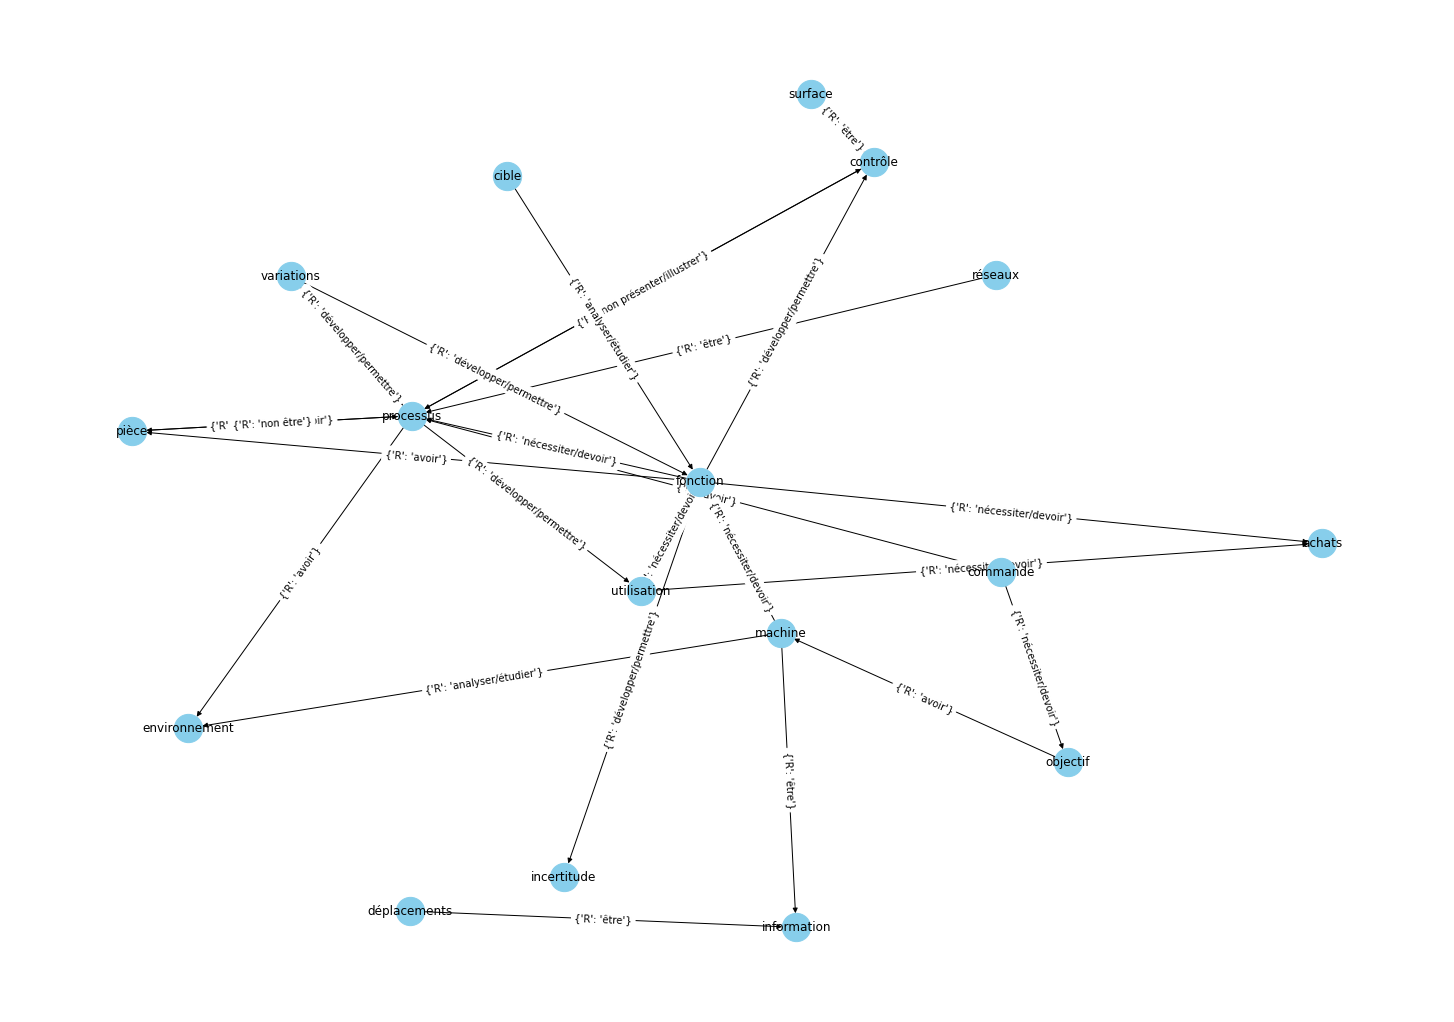

In [22]:
# Plot the generated Knowledge Graph 
df_relations = []
for relation in all_relations_clusterised:
    df_relations += relation
    
df_relations = pd.DataFrame(df_relations, columns=["source", "R", "target"]).drop_duplicates()
df_relations = df_relations[df_relations["source"] != df_relations["target"]]

G = nx.from_pandas_edgelist(df_relations, "source", "target", edge_attr=True, edge_key="R", create_using=nx.MultiDiGraph())

plt.figure(figsize=(20,14))
pos = nx.spring_layout(G, k=1)  # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=800, edge_cmap=plt.cm.Blues, pos=pos)
nx.draw_networkx_edge_labels(G, pos)
plt.show()

### Graph interactif 

In [23]:
from pyvis import network as net

In [24]:
g = net.Network(notebook=True, directed=True, height='500px', width='100%', bgcolor='#222222', font_color='white')

g.from_nx(G)
g.set_edge_smooth(smooth_type="dynamic")
g.show("KG.html")